In [51]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Imports pour le preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Imports pour le preprocessing de texte français
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import unicodedata

# Autres imports
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# Téléchargement des ressources NLTK
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("Ressources NLTK téléchargées avec succès")
except:
    print("Erreur lors du téléchargement des ressources NLTK")

# Configuration
plt.style.use('default')
sns.set_palette("husl")


# Remplace 'chemin/vers/fichier.csv' par le chemin réel vers ton fichier
df = pd.read_csv('amazon_france_random_reviews_20250610_210353.csv', sep = ',', encoding='utf-8')

# Afficher les 5 premières lignes
df.head()

Ressources NLTK téléchargées avec succès


,asin,product_title,product_url,product_rating_category,source_type,reviewer_name,review_rating,review_sentiment,title,date,verified_purchase,review_text,helpful_votes
0,B09TFTHT28,JBL Quantum 100X – Casque de gaming filaire – ...,https://www.amazon.fr/Quantum-100-sur-Oreille-...,good,category_search,Client Kindle,5.0,positive,"5,0 sur 5 étoiles",20 mai 2025,False,"Casque léger et confortable, parfait pour de l...",0
1,B09TFTHT28,JBL Quantum 100X – Casque de gaming filaire – ...,https://www.amazon.fr/Quantum-100-sur-Oreille-...,good,category_search,Qmx,5.0,positive,"5,0 sur 5 étoiles",14 mars 2025,False,J’utilise le JBL Q100X depuis quelques semaine...,4
2,B09TFTHT28,JBL Quantum 100X – Casque de gaming filaire – ...,https://www.amazon.fr/Quantum-100-sur-Oreille-...,good,category_search,stoic,4.0,positive,"4,0 sur 5 étoiles",6 mai 2025,False,"cable jack 10x trop petit, mais sinon a part c...",0
3,B09TFTHT28,JBL Quantum 100X – Casque de gaming filaire – ...,https://www.amazon.fr/Quantum-100-sur-Oreille-...,good,category_search,Artiom,5.0,positive,"5,0 sur 5 étoiles",10 mars 2025,False,Ci-dessous un point de vue après 4 mois d'util...,4
4,B09TFTHT28,JBL Quantum 100X – Casque de gaming filaire – ...,https://www.amazon.fr/Quantum-100-sur-Oreille-...,good,category_search,Brice,5.0,positive,"5,0 sur 5 étoiles",28 avril 2025,False,"1 an maintenant que je l'utilise, il ne m'a po...",0


In [52]:
colonnes_a_garder = ['product_title', 'reviewer_name', 'review_rating', 'date', 'review_text']
df = df[colonnes_a_garder]
# Compter le nombre de commentaires pour chaque rating
compte_par_note = df['review_rating'].value_counts().sort_index()

print(compte_par_note)

review_rating
1.0     174
2.0      62
3.0     237
4.0     622
5.0    3926
Name: count, dtype: int64


In [53]:
def definir_categorie(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutre'
    else:
        return 'negatif'

df['categorie'] = df['review_rating'].apply(definir_categorie)
print(df['categorie'].value_counts())

categorie
positive    4548
neutre       237
negatif      236
Name: count, dtype: int64


In [54]:
# Afficher la distribution actuelle
print("Distribution actuelle:")
print(df['categorie'].value_counts())
print("\nPourcentages:")
print(df['categorie'].value_counts(normalize=True) * 100)

Distribution actuelle:
categorie
positive    4548
neutre       237
negatif      236
Name: count, dtype: int64

Pourcentages:
categorie
positive    90.579566
neutre       4.720175
negatif      4.700259
Name: proportion, dtype: float64


In [55]:
# Séparer les données par catégorie
df_positive = df[df['categorie'] == 'positive']
df_neutre = df[df['categorie'] == 'neutre']
df_negatif = df[df['categorie'] == 'negatif']

In [56]:
print(f"\nNombres par catégorie:")
print(f"Positive: {len(df_positive)}")
print(f"Neutre: {len(df_neutre)}")
print(f"Négatif: {len(df_negatif)}")


Nombres par catégorie:
Positive: 4548
Neutre: 237
Négatif: 236


In [57]:
# Calculer 50% des commentaires positifs
nb_positifs_a_garder = int(len(df_positive) * 0.50)
print(f"\nNombre de commentaires positifs à garder (30%): {nb_positifs_a_garder}")


Nombre de commentaires positifs à garder (30%): 2274


In [58]:
# Échantillonner aléatoirement 7% des commentaires positifs
df_positive_reduit = resample(df_positive, 
                             n_samples=nb_positifs_a_garder, 
                             random_state=42, 
                             replace=False)

In [59]:
# Combiner toutes les catégories
df_equilibre = pd.concat([
    df_positive_reduit,
    df_neutre,
    df_negatif
], ignore_index=True)

# Mélanger les données
df_equilibre = df_equilibre.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nNouvelle distribution:")
print(df_equilibre['categorie'].value_counts())
print(f"\nNouveaux pourcentages:")
print(df_equilibre['categorie'].value_counts(normalize=True) * 100)

print(f"\nTaille du dataset original: {len(df)}")
print(f"Taille du dataset équilibré: {len(df_equilibre)}")
df_equilibre.head()


Nouvelle distribution:
categorie
positive    2274
neutre       237
negatif      236
Name: count, dtype: int64

Nouveaux pourcentages:
categorie
positive    82.781216
neutre       8.627594
negatif      8.591190
Name: proportion, dtype: float64

Taille du dataset original: 5021
Taille du dataset équilibré: 2747


,product_title,reviewer_name,review_rating,date,review_text,categorie
0,"DOOGEE T10S Tablette Android 13【2023】, 11GB + ...",W sumie ok. Natomiast bateria strasznie krótko...,2.0,26 février 2025,Gubi zasięg GPS. Pod kontem nawigacyjnym dalek...,negatif
1,"JBL Wave Beam, Écouteurs Intra-Auriculaires sa...",Hasan Yahsi,1.0,1 juin 2025,Totalement déçu de cet achat ! À l'achat la ba...,negatif
2,"Tefal Ingenio Batterie de cuisine 20 pièces, P...",Encart Christelle,5.0,5 juin 2025,"C’est parfait, je recommande En lire plus",positive
3,Jardin BiO étic - Olives violettes - Grèce 300...,Client d'Amazon,2.0,28 février 2022,"Bonjour, Je viens de recevoir la livraison mai...",negatif
4,"SONGMICS Sitzhocker Banc, Pouf Pliable, 38 x 1...",Moi,5.0,17 mai 2025,"Bon rapport qualité prix, à voir avec le temps...",positive


* PREPROCESSING ET MODELISATION

In [60]:
class FrenchTextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocessor spécialisé pour le texte français
    """
    def __init__(self, remove_stopwords=True, stem=True, min_length=2):
        self.remove_stopwords = remove_stopwords
        self.stem = stem
        self.min_length = min_length
        
        # Initialisation des outils
        self.french_stopwords = set(stopwords.words('french'))
        self.stemmer = SnowballStemmer('french')
        
        # Stopwords supplémentaires spécifiques à Amazon
        amazon_stopwords = {
            'lire', 'plus', 'produit', 'amazon', 'achat', 'acheter', 'commander',
            'livraison', 'prix', 'euro', 'euros', 'article', 'site', 'web',
            'internet', 'online', 'boutique', 'magasin', 'vendeur', 'client'
        }
        self.french_stopwords.update(amazon_stopwords)
        
    def remove_accents(self, text):
        """Supprime les accents du texte"""
        return ''.join(c for c in unicodedata.normalize('NFD', text)
                      if unicodedata.category(c) != 'Mn')
    
    def clean_text(self, text):
        """Nettoie le texte"""
        if pd.isna(text):
            return ""
        
        # Conversion en string et minuscules
        text = str(text).lower()
        
        # Suppression des URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Suppression des mentions email
        text = re.sub(r'\S+@\S+', '', text)
        
        # Suppression des caractères spéciaux mais garde les espaces
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Suppression des chiffres isolés
        text = re.sub(r'\b\d+\b', '', text)
        
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def preprocess_text(self, text):
        """Pipeline de preprocessing complet"""
        # Nettoyage initial
        text = self.clean_text(text)
        
        if not text:
            return ""
        
        try:
            # Tokenisation
            tokens = word_tokenize(text, language='french')
            
            # Filtrage des tokens
            processed_tokens = []
            for token in tokens:
                # Filtrer les tokens trop courts
                if len(token) < self.min_length:
                    continue
                    
                # Suppression des stopwords
                if self.remove_stopwords and token in self.french_stopwords:
                    continue
                    
                # Stemming
                if self.stem:
                    token = self.stemmer.stem(token)
                
                processed_tokens.append(token)
            
            return ' '.join(processed_tokens)
            
        except Exception as e:
            print(f"Erreur lors du preprocessing: {e}")
            return text
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Transforme une série de textes"""
        if isinstance(X, pd.Series):
            return X.apply(self.preprocess_text)
        elif isinstance(X, list):
            return [self.preprocess_text(text) for text in X]
        else:
            return [self.preprocess_text(str(text)) for text in X]

def evaluate_models(X_train, X_test, y_train, y_test, models_dict):
    """
    Évalue plusieurs modèles et retourne leurs performances
    """
    results = {}
    
    print("Évaluation des modèles...")
    print("=" * 50)
    
    for name, model in models_dict.items():
        print(f"\nEntraînement de {name}...")
        
        # Entraînement
        model.fit(X_train, y_train)
        
        # Prédictions
        y_pred = model.predict(X_test)
        
        # Métriques
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        
        # Validation croisée
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        print(f"CV Score (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return results

def create_pipeline(best_model, preprocessor, vectorizer):
    """
    Crée le pipeline final avec le meilleur modèle
    """
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('vectorizer', vectorizer),
        ('classifier', best_model)
    ])
    return pipeline

def plot_results(results):
    """
    Visualise les résultats des modèles
    """
    # Préparer les données pour le graphique
    models = list(results.keys())
    f1_scores = [results[model]['f1_weighted'] for model in models]
    cv_scores = [results[model]['cv_mean'] for model in models]
    cv_stds = [results[model]['cv_std'] for model in models]
    
    # Créer le graphique
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # F1 Score sur le test set
    bars1 = ax1.bar(models, f1_scores, color='skyblue', alpha=0.7)
    ax1.set_title('F1 Score (weighted) sur le Test Set')
    ax1.set_ylabel('F1 Score')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, score in zip(bars1, f1_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # Validation croisée
    bars2 = ax2.bar(models, cv_scores, yerr=cv_stds, color='lightcoral', alpha=0.7, capsize=5)
    ax2.set_title('Validation Croisée (F1 weighted)')
    ax2.set_ylabel('F1 Score (CV)')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, score in zip(bars2, cv_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def main(df_equilibre):
    """
    Fonction principale du pipeline
    """
    print("PIPELINE DE CLASSIFICATION NLP - COMMENTAIRES AMAZON FRANCE")
    print("=" * 70)
    
    # Vérification des données fournies
    print(f"\nUtilisation de vos données préprocessées...")
    print(f"Dataset fourni: {len(df_equilibre)} commentaires")
    print(f"Distribution des classes:")
    print(df_equilibre['categorie'].value_counts())
    
    # 3. Préparation des features et target
    X = df_equilibre['review_text']
    y = df_equilibre['categorie']
    
    # 4. Division train/test
    print("\nDivision des données...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Données divisées: Train({len(X_train)}) / Test({len(X_test)})")
    
    # 5. Preprocessing du texte
    print("\nPreprocessing du texte français...")
    text_preprocessor = FrenchTextPreprocessor(
        remove_stopwords=True,
        stem=True,
        min_length=2
    )
    
    # Appliquer le preprocessing
    X_train_processed = text_preprocessor.transform(X_train)
    X_test_processed = text_preprocessor.transform(X_test)
    
    # 6. Vectorisation
    print("\nVectorisation TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8
    )
    
    X_train_vectorized = vectorizer.fit_transform(X_train_processed)
    X_test_vectorized = vectorizer.transform(X_test_processed)
    
    print(f"Vectorisation terminée: {X_train_vectorized.shape[1]} features")
    
    # 7. Définition des modèles à tester
    print("\nPréparation des modèles...")
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
        'SVM': SVC(random_state=42, class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
    }
    
    # 8. Évaluation des modèles
    print("\nÉvaluation des modèles...")
    results = evaluate_models(X_train_vectorized, X_test_vectorized, y_train, y_test, models)
    
    # 9. Sélection du meilleur modèle
    best_model_name = max(results.keys(), key=lambda k: results[k]['f1_weighted'])
    best_model = results[best_model_name]['model']
    
    print(f"\nMeilleur modèle: {best_model_name}")
    print(f"F1 Score (weighted): {results[best_model_name]['f1_weighted']:.4f}")
    
    # 10. Création du pipeline final
    print("\nCréation du pipeline final...")
    final_pipeline = create_pipeline(best_model, text_preprocessor, vectorizer)
    
    # Entraîner le pipeline complet
    final_pipeline.fit(X_train, y_train)
    
    # 11. Test final du pipeline
    print("\nTest final du pipeline...")
    y_pred_final = final_pipeline.predict(X_test)
    final_f1 = f1_score(y_test, y_pred_final, average='weighted')
    final_accuracy = accuracy_score(y_test, y_pred_final)
    
    print(f"Performance finale:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"F1 Score (weighted): {final_f1:.4f}")
    
    # Rapport de classification détaillé
    print("\nRapport de classification détaillé:")
    print(classification_report(y_test, y_pred_final))
    
    # 12. Sauvegarde du pipeline
    print("\nSauvegarde du pipeline...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    pipeline_filename = f'pipeline_amazon_fr_{best_model_name.lower().replace(" ", "_")}_{timestamp}.pkl'
    
    joblib.dump(final_pipeline, pipeline_filename)
    print(f"Pipeline sauvegardé: {pipeline_filename}")
    
    # 13. Sauvegarde des métadonnées
    metadata = {
        'model_name': best_model_name,
        'f1_score': final_f1,
        'accuracy': final_accuracy,
        'train_size': len(X_train),
        'test_size': len(X_test),
        'features_count': X_train_vectorized.shape[1],
        'classes': list(y.unique()),
        'timestamp': timestamp
    }
    
    import json
    metadata_filename = f'metadata_amazon_fr_{timestamp}.json'
    with open(metadata_filename, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    print(f"Métadonnées sauvegardées: {metadata_filename}")
    
    # 14. Visualisation des résultats
    print("\nGénération des graphiques...")
    plot_results(results)
    
    # 15. Test avec vos propres exemples
    print("\nTest avec quelques exemples de vos données:")
    # Prendre quelques exemples aléatoires de vos données pour test
    echantillon_test = df_equilibre.sample(n=3, random_state=42)
    
    for idx, row in echantillon_test.iterrows():
        texte = row['review_text']
        vraie_categorie = row['categorie']
        prediction = final_pipeline.predict([texte])[0]
        
        print(f"\nTexte: '{texte[:100]}...'")
        print(f"Vraie catégorie: {vraie_categorie} | Prédiction: {prediction}")
        if vraie_categorie == prediction:
            print("Correct")
        else:
            print("Incorrect")
    
    print(f"\n Pipeline terminé! Fichier principal: {pipeline_filename}")
    
    return final_pipeline, results

# Fonction pour charger et utiliser le pipeline sauvegardé
def load_and_predict(pipeline_path, texts):
    """
    Charge un pipeline sauvegardé et fait des prédictions
    
    Args:
        pipeline_path (str): Chemin vers le fichier .pkl du pipeline
        texts (list): Liste de textes à classifier
    
    Returns:
        list: Prédictions pour chaque texte
    """
    # Charger le pipeline
    pipeline = joblib.load(pipeline_path)
    
    # Faire les prédictions
    predictions = pipeline.predict(texts)
    
    return predictions

if __name__ == "__main__":
    # Charger vos données préprocessées
    print("Chargement de vos données préprocessées...")

Chargement de vos données préprocessées...


PIPELINE DE CLASSIFICATION NLP - COMMENTAIRES AMAZON FRANCE

Utilisation de vos données préprocessées...
Dataset fourni: 2747 commentaires
Distribution des classes:
categorie
positive    2274
neutre       237
negatif      236
Name: count, dtype: int64

Division des données...
Données divisées: Train(2197) / Test(550)

Preprocessing du texte français...

Vectorisation TF-IDF...
Vectorisation terminée: 5000 features

Préparation des modèles...

Évaluation des modèles...
Évaluation des modèles...

Entraînement de Logistic Regression...
Accuracy: 0.8364
F1 Score (weighted): 0.8377
F1 Score (macro): 0.6322
CV Score (mean ± std): 0.8525 ± 0.0109

Entraînement de Random Forest...
Accuracy: 0.8527
F1 Score (weighted): 0.8320
F1 Score (macro): 0.5881
CV Score (mean ± std): 0.8292 ± 0.0151

Entraînement de SVM...
Accuracy: 0.8582
F1 Score (weighted): 0.8383
F1 Score (macro): 0.6031
CV Score (mean ± std): 0.8333 ± 0.0123

Entraînement de Naive Bayes...
Accuracy: 0.8473
F1 Score (weighted): 0.7932

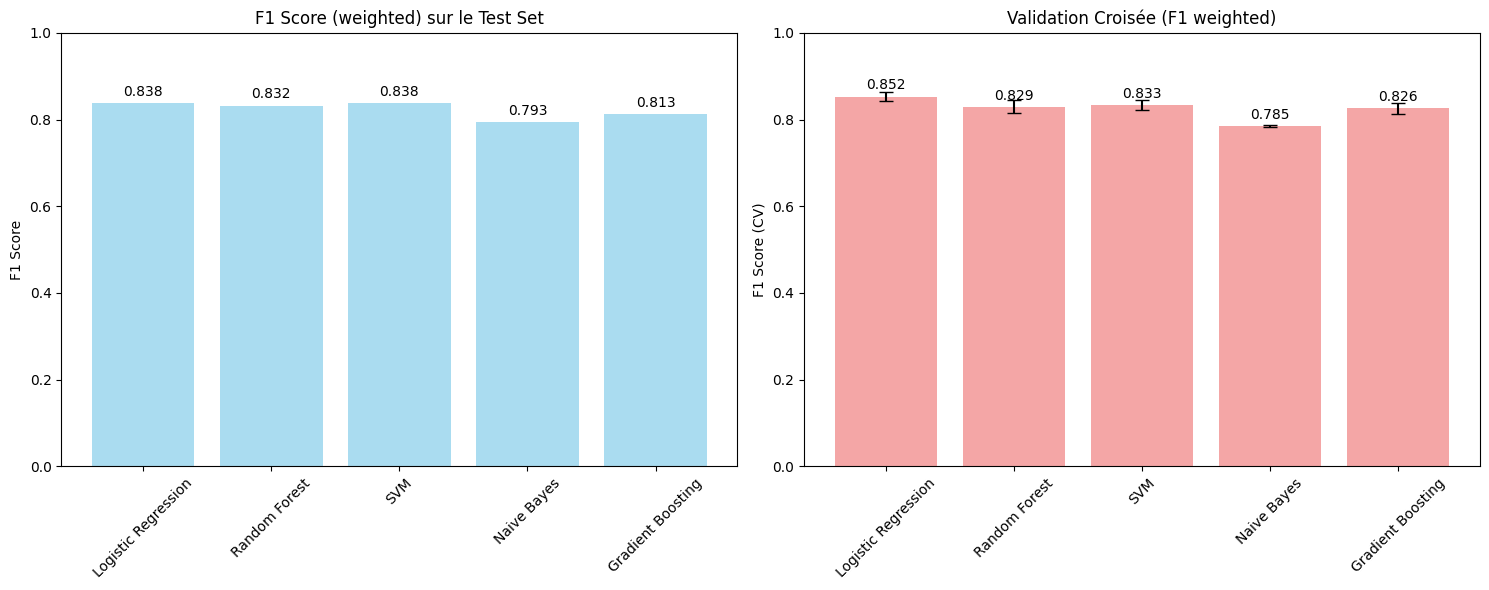


Test avec quelques exemples de vos données:

Texte: 'Ottimo En lire plus...'
Vraie catégorie: neutre | Prédiction: neutre
Correct

Texte: 'Bonne qualité En lire plus...'
Vraie catégorie: positive | Prédiction: positive
Correct

Texte: 'Le début est très lent mais arrivé au milieux du livre on arrive plus a décrocher. Je le conseille ....'
Vraie catégorie: positive | Prédiction: positive
Correct

 Pipeline terminé! Fichier principal: pipeline_amazon_fr_svm_20250611_002538.pkl


In [62]:
pipeline, results = main(df_equilibre)